In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output,return_layer_input
import torch
import pandas as pd
from torch.autograd import Variable

In [4]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/hybrid1.pth')
#hybrid_model = hybrid_model.cuda()

## Datasets creation

In [5]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [7]:
testneg_classifier_inputs,testneg_ids = return_layer_input('../../Structured/itunes-amazon/'
                                                                         ,'test_negatives',64,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [ ]:
testpos_classifier_inputs,testpos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'test_positives',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [8]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [10]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier,device=-1)

In [11]:
hybrid_model = hybrid_model.cuda()

## Utility methods

In [12]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change

## Negative sample analysis

In [16]:
from tqdm import tqdm

In [17]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri = []
for batch in neg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1,
                                                                                   learning_rate=2),attributes))
        negatives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [04:14<00:00,  1.99s/it]


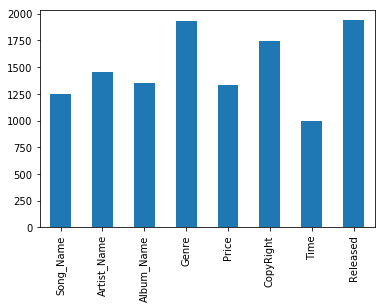

In [20]:
ri_norms_negative_samples = []
for ri_list in negatives_ri:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
neg_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
neg_variation_df.sum().plot.bar()

In [21]:
neg_variation_df.to_csv('experiments-results/exp3/negatives_ri_v2.csv',index=False)

## Positive samples analisys

In [24]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in pos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0,
                                                                                   learning_rate=2),attributes))
        positives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


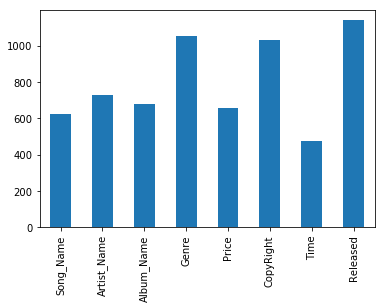

In [26]:
ri_norms_pos = []
for ri_list in positives_ri:
    ri_norms_pos.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
pos_variation_df = pd.DataFrame(data= ri_norms_pos,columns=attributes)
pos_variation_df.sum().plot.bar()

In [27]:
pos_variation_df.to_csv('experiments-results/exp3/positives_ri_v2.csv',index=False)

## Finding closer vectors

In [ ]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [ ]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in neg_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri_matrix[i][attributes.index(att)]
                                                                ,pos_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in pos_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri_matrix[i][attributes.index(att)]
                                                                ,neg_classifier_inputs,attributes.index(att),
                                                                150,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [ ]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c: pos_ids[c])

In [ ]:
positives_closer_vectors_df['SampleID'] = pos_ids
negatives_closer_vectors_df['SampleID'] = neg_ids

In [ ]:
positives_closer_vectors_df.to_csv('experiments-results/exp3/positives_nn.csv',index=False)
negatives_closer_vectors_df.to_csv('experiments-results/exp3/negatives_nn.csv',index=False)

### Compare nearest neighbours of exp.6 to near. neighbours of exp.3

In [ ]:
negatives = pd.read_csv('../../Structured/itunes-amazon/negatives.csv')
positives = pd.read_csv('../../Structured/itunes-amazon/positives.csv')

In [ ]:
positives_nn_exp3 = pd.read_csv('experiments-results/exp3/positives_nn.csv')
negatives_nn_exp3 = pd.read_csv('experiments-results/exp3/negatives_nn.csv')
positives_nn_exp6 = pd.read_csv('experiments-results/exp6/positives_numeric_nn.csv')
negatives_nn_exp6 = pd.read_csv('experiments-results/exp6/negatives_numeric_nn.csv')

In [ ]:
nn_onAlbum_exp3 = pd.merge(positives_nn_exp3,negatives,left_on='Album_Name',right_on='id')

In [ ]:
(nn_onAlbum_exp3['ltable_Album_Name']+" | "+nn_onAlbum_exp3['rtable_Album_Name']).value_counts()

In [ ]:
nn_onAlbum_exp6 = pd.merge(positives_nn_exp6,negatives,left_on='Album_Name',right_on='id')

In [ ]:
(nn_onAlbum_exp6['ltable_Album_Name']+" | "+nn_onAlbum_exp6['rtable_Album_Name']).value_counts()

In [ ]:
negnn_onArtist_exp6 = pd.merge(negatives_nn_exp6,positives,left_on='Artist_Name',right_on='id')

In [ ]:
(negnn_onArtist_exp6['ltable_Artist_Name']+" | "+negnn_onArtist_exp6['rtable_Artist_Name']).value_counts()

In [ ]:
negnn_onArtist_exp3 = pd.merge(negatives_nn_exp3,positives,left_on='Artist_Name',right_on='id')

In [ ]:
(negnn_onArtist_exp3['ltable_Artist_Name']+" | "+negnn_onArtist_exp3['rtable_Artist_Name']).value_counts()

### Analyze nearest neighbours on artist name

In [ ]:
nn_onArtist = pd.merge(positives_closer_vectors_df,negatives,left_on='Artist_Name',right_on='id')

In [ ]:
nn_onArtist[['ltable_Artist_Name','rtable_Artist_Name']].head(30)

### Nearest Neighbours on Time

In [ ]:
nearest_neighbours_onTime = pd.merge(negatives_closer_vectors_df,positives,left_on='Time',right_on='id')

In [ ]:
nearest_neighbours_onTime['rtable_Time'].unique()

In [ ]:
it,variation = find_smallest_variation_to_change(hybrid_model.classifier,positive_classifier_inputs[0],20,6,0)

In [ ]:
positive_classifier_inputs[0][20].data = positive_classifier_inputs[0][20].data.copy_(positive_classifier_inputs[0][20].data+
                                                                                     variation.data)

In [ ]:
hybrid_model.classifier.forward(positive_classifier_inputs[0])[20]

In [ ]:
grads_list = []
h = positive_classifier_inputs[0].register_hook(lambda g: grads_list.append(g))

In [ ]:
out = hybrid_model.classifier.forward(positive_classifier_inputs[0])
prob = get_probabilites(out[20])

In [ ]:
from torch.autograd import Variable
true_labels = Variable (torch.cuda.FloatTensor([0,1]))